In [123]:
import importlib

import torch
from constants import *
import utils
importlib.reload(utils)

CLASSIFIED_STATES = ['boredom', 'flow', 'frustration', 'neutral']

print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Device: ", device)

CUDA Available:  False
Current Device:  cpu


In [53]:
X_train_init, y_train_init = utils.load_testing_data(CLASSIFIED_STATES)
X_train_init.shape, y_train_init.shape

(torch.Size([5832, 25, 40]), torch.Size([5832, 4]))

In [5]:
X_train = X_train_init.mean(axis=1) # [:100, :]
y_train = y_train_init # [:100, :]
X_train.shape, y_train.shape

(torch.Size([5832, 40]), torch.Size([5832, 4]))

In [6]:
from sklearn.svm import SVC
from skl2onnx import to_onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx.helpers.onnx_helper import select_model_inputs_outputs

svm = None
svm_onnx = None
for i, y_class in enumerate(CLASSIFIED_STATES):
    print(f"Training for {y_class}")
    svm = SVC(kernel='linear', C=1.0, random_state=42, probability=True) 
    y = y_train[:, i]
    svm.fit(X_train, y)

    # export to onnx
    initial_type = [('X', FloatTensorType([None, X_train.shape[1]]))]
    svm_onnx = to_onnx(svm, X_train, initial_types=initial_type)
    svm_onnx = select_model_inputs_outputs(svm_onnx, outputs=['probabilities'])

    with open(f"{EXPORTED_MODELS_PATH}/svm_{y_class}.onnx", "wb") as f:
        f.write(svm_onnx.SerializeToString())
        

Training for boredom
Training for flow
Training for frustration
Training for neutral


### Validate the results and compatre onnx with sklearn

In [8]:
# % pip install onnxruntime==1.18.1
import onnxruntime as rt
import numpy as np

example_x = X_train[y_train[:, 0] == 1][:3, :] # boredom has index 0
print(example_x.shape)

session = rt.InferenceSession(f"{EXPORTED_MODELS_PATH}/svm_neutral.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
label_name = [o.name for o in session.get_outputs()]
 
print(f'input={input_name}, output={label_name}')

print(f'onnx pred: {session.run(label_name, {input_name: example_x.numpy().astype(np.float32)})}')
print(f'sklearn pred: {svm.predict_proba(example_x)}')

torch.Size([3, 40])
input=Z, output=['probabilities']
onnx pred: [array([[6.8857718e-01, 3.1142274e-01],
       [9.9994624e-01, 5.3766275e-05],
       [7.8322035e-01, 2.1677954e-01]], dtype=float32)]
sklearn pred: [[0.73132052 0.26867948]
 [0.90191387 0.09808613]
 [0.93983349 0.06016651]]


### Validate the model

#### One by one

In [136]:
from sklearn.metrics import mean_squared_error as MSE

X_test, y_test = utils.load_testing_data(states=CLASSIFIED_STATES)
X_test = X_test.mean(axis=1)

for i, state in enumerate(CLASSIFIED_STATES):
  y_test_i = y_test[:, i].numpy()

  session = rt.InferenceSession(f"{EXPORTED_MODELS_PATH}/svm_{state}.onnx", providers=["CPUExecutionProvider"])
  input_name = session.get_inputs()[0].name
  label_name = [o.name for o in session.get_outputs()]
  preds = session.run(label_name, {input_name: X_test.numpy().astype(np.float32)})
  preds = np.array(preds[0])[:, 0]

  print(f'Predicting for {state}: {MSE(preds, y_test_i)}')

Predicting for boredom: 0.48299548029899597
Predicting for flow: 0.4976547062397003
Predicting for frustration: 0.531104326248169
Predicting for neutral: 0.5129537582397461


### As one entity

In [125]:
class ONNXSVM:
  def __init__(self, state):
    self.classes = state
    self.svm = rt.InferenceSession(f"{EXPORTED_MODELS_PATH}/svm_{state}.onnx", providers=["CPUExecutionProvider"])
    self.input_name = self.svm.get_inputs()[0].name
    self.label_name = [o.name for o in self.svm.get_outputs()]
  
  def predict(self, X):
    preds = self.svm.run(self.label_name, {self.input_name: X.numpy().astype(np.float32)})
    return np.array(preds[0])[:, 0]

class MultiClassSVM:
  def __init__(self, classes):
    self.SVMS = [ONNXSVM(state) for state in classes]

  def forward(self, X):
    return X.mean(axis=1)

  def predict_proba(self, X):
    X = self.forward(X)
    preds = np.array([svm.predict(X) for svm in self.SVMS]).T
    return preds
  
  def predict(self, X):
    preds = self.predict_proba(X)
    return np.argmax(preds, axis=1)
  
  def mse_per_class(self, X, y):
    preds = self.predict_proba(X)
    return [MSE(preds[:, i], y[:, i]) for i in range(len(self.SVMS))]
  
  def accuracy(self, X, y):
    predicted_ids = self.predict(X)
    target_ids = np.argmax(y, axis=1)
    return (predicted_ids == target_ids).mean()
    

multi_svm = MultiClassSVM(CLASSIFIED_STATES)
X_test, y_test = utils.load_testing_data(states=CLASSIFIED_STATES)

y_test = y_test.numpy()

preds_proba = multi_svm.predict_proba(X_test)
preds = multi_svm.predict(X_test)

In [126]:
multi_svm.mse_per_class(X_test, y_test), multi_svm.accuracy(X_test, y_test)

([0.48299548, 0.49765477, 0.5311043, 0.51295376], 0.151920438957476)

In [127]:
preds_proba, preds

(array([[0.04378931, 0.40158644, 0.92727005, 0.780943  ],
        [0.97902256, 0.7092874 , 0.7085951 , 0.53682214],
        [0.04465177, 0.81572837, 0.64123017, 0.99497956],
        ...,
        [0.62574124, 0.72872216, 0.76413924, 0.76582664],
        [0.18687055, 0.80740154, 0.8660705 , 0.9063135 ],
        [0.7943504 , 0.82903546, 0.5347151 , 0.64515984]], dtype=float32),
 array([2, 0, 3, ..., 3, 3, 1]))

Text(0, 0.5, 'Counts')

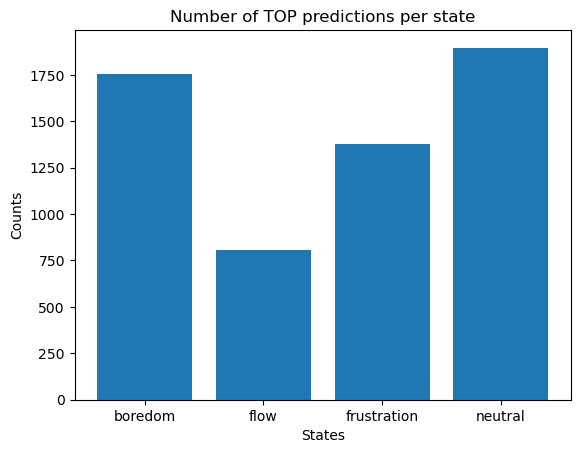

In [130]:
import matplotlib.pyplot as plt

values, counts = np.unique(preds, return_counts=True)
plt.bar(CLASSIFIED_STATES, counts)
plt.title("Number of TOP predictions per state")
plt.xlabel("States")
plt.ylabel("Counts")
